# Food Volume Estimation from input image
Using the trained monocular depth estimation network and a segmentation model we will estimate the volume of the food displayed in the input image

In [1]:
import sys
sys.path.append('../code')
import numpy as np
import pandas as pd
import cv2
import json
from keras.models import Model, model_from_json
import keras.backend as K
from estimate_volume import VolumeEstimator
from custom_modules import *
from project import *
from point_cloud_utils import *
import matplotlib.pyplot as plt


# Create estimator object without initialization
estimator = VolumeEstimator(arg_init=False)
# Initialize explicitly
with open('../code/trained_models/monovideo_low_res.json', 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json,
                                          custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights('../code/trained_models/monovideo_low_res.h5')
estimator.model_input_shape = estimator.monovideo.inputs[0].shape[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs,
                              outputs=depth_net.outputs,
                              name='depth_model')
print('[*] Loaded depth estimation model.')
# Depth model configuration
min_depth = 0.01
max_depth = 10
estimator.DEPTH_RESCALING = 0.55
estimator.min_disp = 1 / max_depth
estimator.max_disp = 1 / min_depth
# Select segmentation model to use
segmentation_model = 'GAP'
estimator._VolumeEstimator__select_segmentation_module(segmentation_model)
estimator.segmentation_weights = '../code/segmentation/weights.epoch-15-val_loss-0.85.hdf5'
print('[*] Selected', segmentation_model, 'as the segmentation model.')

Using TensorFlow backend.


[*] VolumeEstimator not initialized.
Instructions for updating:
Colocations handled automatically by placer.


W0625 17:08:59.121720 140390558209856 deprecation.py:323] From /home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use the `axis` argument instead


W0625 17:09:04.565764 140390558209856 deprecation.py:506] From ../code/project.py:205: calling squeeze (from tensorflow.python.ops.array_ops) with squeeze_dims is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


Instructions for updating:
Use tf.cast instead.


W0625 17:09:04.663422 140390558209856 deprecation.py:323] From ../code/project.py:243: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


[*] Loaded depth estimation model.
[*] Selected GAP as the segmentation model.


Using the outputs from the estimator we create and visualize the object, plate and estimated plane point clouds.

[*] Creating intrinsics matrix from given FOV: 71
[*] Estimated plane parameters (w0,w1,w2,w3): [0.5189290046691895, 0.019465437158942223, 0.11050622910261154, -1]
[*] Estimated volume: 2.030379026601328 L


<IPython.core.display.Javascript object>


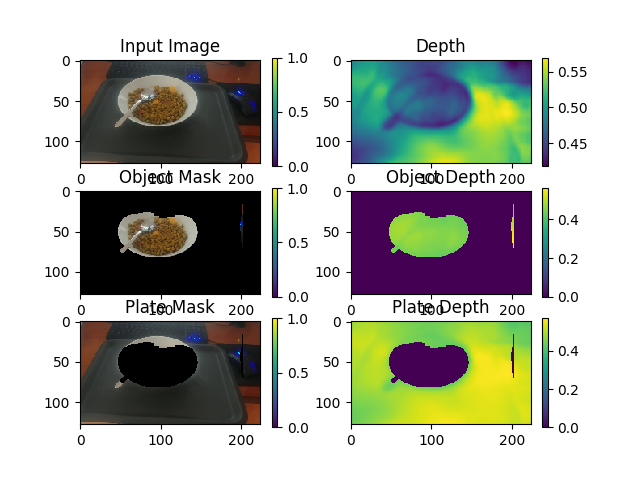

/home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/pythreejs/traits.py:177: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.04134263784635451, 0.022149957560699096, 0…

In [6]:
from pyntcloud import PyntCloud

%matplotlib notebook
outputs = estimator.estimate_volume('../assets/volume_tests/various_foods_test/test_2.jpg', fov=71, plot_results=True)
(_, object_points_df, plate_points_df, plane_points_df, object_points_transformed_df, 
 plane_points_transformed_df, simplices) = outputs

# Flip x and z axes to match point cloud with plot axes
object_points_df.values[:,0] *= -1
object_points_df.values[:,2] *= -1
plate_points_df.values[:,0] *= -1
plate_points_df.values[:,2] *= -1
plane_points_df.values[:,0] *= -1
plane_points_df.values[:,2] *= -1
# Create point cloud objects and plot
object_pc = PyntCloud(object_points_df)
plate_pc = PyntCloud(plate_points_df)
plane_pc = PyntCloud(plane_points_df)
scene = object_pc.plot(initial_point_size=0.001, return_scene=True)
plate_pc.plot(initial_point_size=0.001, scene=scene)
plane_pc.plot(initial_point_size=0.005, use_as_color='z', cmap='cool', scene=scene)

Plot the transformed object and plate point clouds and the object triangulation on the XY plane.

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.03798066312233163, 0.19851742578406847, 0…

<IPython.core.display.Javascript object>


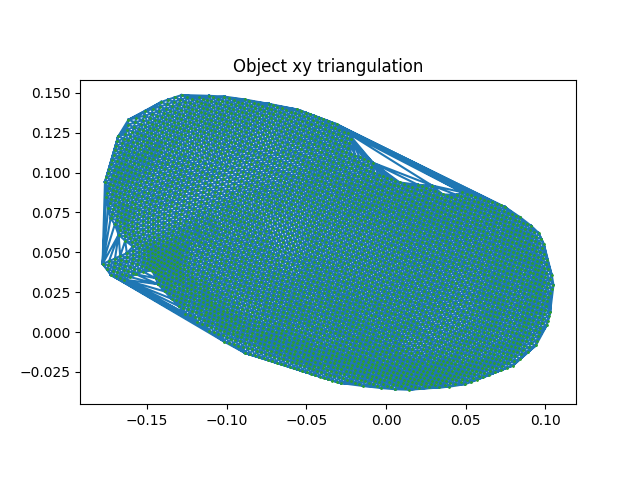

In [7]:
# Create transformed point clouds and plot
plane_transformed_pc = PyntCloud(plane_points_transformed_df)
object_transformed_pc = PyntCloud(object_points_transformed_df)
scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

# Plot xy plane triangulation
%matplotlib notebook
object_points_transformed = object_points_transformed_df.values
plt.figure()
plt.triplot(object_points_transformed[:,0], object_points_transformed[:,1], simplices)
plt.plot(object_points_transformed[:,0], object_points_transformed[:,1], 'o', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Object xy triangulation')
plt.show()